# Import

In [1]:
import sys
sys.path.append("..")

import pandas as pd
import numpy as np
from common import *
from glob import glob
from os import rename, path
from gensim import corpora
from os.path import basename
from gensim.models import Word2Vec
from itertools import islice
from operator import itemgetter
from tqdm import tqdm

from joblib import Parallel, delayed
import pickle, json
from numba import jit

from matplotlib import pyplot as plt

import gensim
from gensim import corpora, models, similarities
from sklearn.metrics.pairwise import cosine_similarity

import multiprocessing
import copy, logging

cpu_count = multiprocessing.cpu_count() -1

DATA_FOLDER = '../data/'
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.


# Prepare data

In [2]:
all_docs = get_all_docs(DATA_FOLDER)

In [3]:
dictionary = corpora.Dictionary.load(join(DATA_FOLDER, 'pure.dict'))
corpus = corpora.MmCorpus(join(DATA_FOLDER, 'pure_corpus.mm'))

2017-07-20 23:51:10,352 : INFO : loading Dictionary object from ../data/pure.dict
2017-07-20 23:51:11,886 : INFO : loaded ../data/pure.dict
2017-07-20 23:51:12,024 : INFO : loaded corpus index from ../data/pure_corpus.mm.index
2017-07-20 23:51:12,025 : INFO : initializing corpus reader from ../data/pure_corpus.mm
2017-07-20 23:51:12,028 : INFO : accepted corpus with 1194429 documents, 2316883 features, 195209119 non-zero entries


In [4]:
print(corpus)

MmCorpus(1194429 documents, 2316883 features, 195209119 non-zero entries)


In [5]:
fmodel = join(DATA_FOLDER, 'tfidf_pure.model')
if not path.exists(fmodel):    
    tfidf = models.TfidfModel(corpus)
    tfidf.save(fmodel)
else:
    tfidf = models.TfidfModel.load(fmodel)

2017-07-20 23:51:12,041 : INFO : loading TfidfModel object from ../data/tfidf_pure.model
2017-07-20 23:51:12,559 : INFO : loaded ../data/tfidf_pure.model


In [6]:
model = gensim.models.Word2Vec.load(join(DATA_FOLDER, 'vectors/w2v_model_300_w3'))
wv = model.wv

2017-07-20 23:51:24,546 : INFO : loading Word2Vec object from ../data/vectors/w2v_model_300_w3
2017-07-20 23:51:26,747 : INFO : loading wv recursively from ../data/vectors/w2v_model_300_w3.wv.* with mmap=None
2017-07-20 23:51:26,748 : INFO : loading syn0 from ../data/vectors/w2v_model_300_w3.wv.syn0.npy with mmap=None
2017-07-20 23:51:28,566 : INFO : setting ignored attribute syn0norm to None
2017-07-20 23:51:28,567 : INFO : loading syn1neg from ../data/vectors/w2v_model_300_w3.syn1neg.npy with mmap=None
2017-07-20 23:51:30,325 : INFO : setting ignored attribute cum_table to None
2017-07-20 23:51:30,326 : INFO : loaded ../data/vectors/w2v_model_300_w3


In [13]:
# wv.most_similar(positive=['стена'], topn=10)

In [7]:
with open(join(DATA_FOLDER, 'gold.json'), 'r') as f:
    gold = json.load(f)

In [8]:
val_docs = glob(join(DATA_FOLDER, 'validate/*.txt'))


# Main functions

In [9]:
NWORDS = 15

In [10]:
def like(wv, what):
    """
    get first in the list with given pos tag
    """
    pos = ('_NOUN', '_VERB', '_ADJ', '_ADV')
    pos = ('_S', '_V', '_A', '_ADV')
    return next((wv[what + p] for p in pos if what + p in wv), None)


def like2(wv, what):
    try:
        return wv[what]
    except: 
        return None

In [11]:
@jit
def tovec(doc_tfidf, wv, dictionary):
    sorted_tfidf = sorted(doc_tfidf, key=itemgetter(1), reverse=True)
    for k,v in sorted_tfidf:
        pair = (like2(wv, dictionary.get(k)), v)
        if pair[0] is not None:
            yield pair

In [12]:
def doc_vec(doc_tfidf, wv, nwords=10):
    # take top 10 most meaningfull
    valid_tokens = tovec(doc_tfidf, wv, dictionary)
    vec_score = np.array([x for x in islice(valid_tokens, nwords)])
    if len(vec_score) == 0:
        return np.zeros(wv.syn0.shape[1])
    docvec = np.mean(vec_score[:, 0] * softmax(vec_score[:, 1]), axis=0) 

    return docvec

In [13]:
val_vecs = []
val_names = []
for fname in tqdm(val_docs):
    with open(fname, 'r') as f:
        doc_text = f.read()
    doc_bow = dictionary.doc2bow(tokenize(doc_text))
    docvec = doc_vec(tfidf[doc_bow], wv, NWORDS)
    name = path.splitext(basename(fname))[0]
    val_names.append(name)
    val_vecs.append(docvec)

# test_vecs = pd.DataFrame.from_dict(test_vecs, orient='index')

100%|██████████| 130/130 [00:00<00:00, 139.43it/s]


In [15]:
len(val_vecs)

130

In [16]:
train_vecs = []
train_names = []
for key, doc_tfidf in enumerate(tqdm(tfidf[corpus])):
    docvec = doc_vec(doc_tfidf, wv, NWORDS)
    fname = all_docs[key]
    name = path.splitext(basename(fname))[0]
    train_names.append(name)
    train_vecs.append(docvec)

100%|██████████| 1194429/1194429 [17:39<00:00, 1126.99it/s]


In [17]:
len(train_vecs)

1194429

In [18]:
! mkdir -p {join(DATA_FOLDER, 'saved/')}

### write

In [19]:
with open(join(DATA_FOLDER, 'saved/train.pkl'), 'wb') as f:
    pickle.dump([train_vecs, train_names], f)

In [20]:
with open(join(DATA_FOLDER, 'saved/val.pkl'), 'wb') as f:
    pickle.dump([val_vecs, val_names], f)

### read

In [2]:
with open(join(DATA_FOLDER, 'saved/train.pkl'), 'rb') as f:
    train_vecs, train_names = pickle.load(f)

In [3]:
with open(join(DATA_FOLDER, 'saved/val.pkl'), 'rb') as f:
    val_vecs, val_names = pickle.load(f)

# Similarity

In [21]:
sim_mat = cosine_similarity(val_vecs, train_vecs)

In [22]:
best = {}
for i, vec in enumerate(tqdm(sim_mat)):
    val_name = val_names[i]
    train_ixs = vec.argsort()[-200:][::-1]
    top_train = [train_names[i] for i in train_ixs]
    best[val_name] = top_train

100%|██████████| 130/130 [00:19<00:00,  6.58it/s]


In [52]:
with open(join(DATA_FOLDER, 'best.json'), 'w') as f:
    json.dump(best, f)

median
acc10     0.0
acc20     0.0
acc200    0.5
dtype: float64
mean
acc10     0.297436
acc20     0.384872
acc200    0.548846
dtype: float64


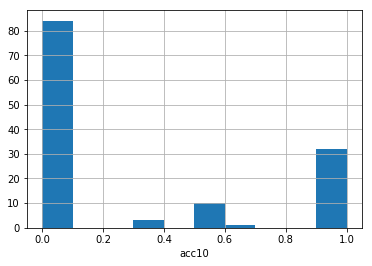

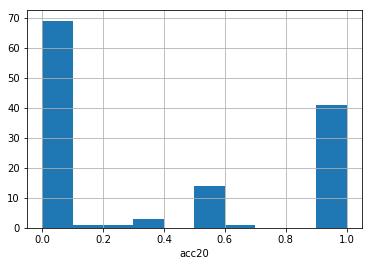

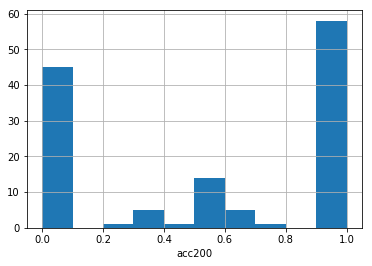

In [23]:
res = evaluate(best, gold)

# Experiments

# Save

In [19]:
test_vecs = np.array(test_vecs)
train_vecs = np.array(train_vecs)

In [20]:
# np.save(join(DATA_FOLDER, 'bov_test_vecs.npy'), test_vecs)
# np.save(join(DATA_FOLDER, 'bov_train_vecs.npy'), train_vecs)

# Tensorboard visualization

In [88]:
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

from operator import itemgetter 
from random import sample

In [89]:
# subsample to managebale size
samp_ixs = sample(range(len(train_vecs)), 99800)
samp = list(itemgetter(*samp_ixs)(train_vecs)) + test_vecs
samp_names = list(itemgetter(*samp_ixs)(train_names)) + test_names

In [90]:
vocab_size = len(samp)
embedding_dim = model.vector_size

W = tf.Variable(tf.constant(0.0, shape=[vocab_size, embedding_dim]),
                trainable=False, name="W")
embedding_placeholder = tf.placeholder(tf.float32, [vocab_size, embedding_dim])
embedding_init = W.assign(embedding_placeholder)

In [91]:
import csv

vocab = dict(enumerate(samp_names))
vdf = pd.DataFrame.from_dict(vocab, orient='index')
vdf.to_csv('../data/processed_docs/vocab.tsv', header=False, sep='\t', index=False)


In [92]:
with tf.Session() as sess:
    final_embed_matrix = sess.run(embedding_init, feed_dict={embedding_placeholder: samp})
    
#     final_embed_matrix = sess.run(weights)

    # it has to variable. constants don't work here. you can't reuse model.embed_matrix
    embedding_var = tf.Variable(final_embed_matrix, name='documents')
    sess.run(embedding_var.initializer)

    config = projector.ProjectorConfig()
    summary_writer = tf.summary.FileWriter('../data/processed_docs')

    # add embedding to the config file
    embedding = config.embeddings.add()
    embedding.tensor_name = embedding_var.name

    # link this tensor to its metadata file, in this case the first 500 words of vocab
    embedding.metadata_path = 'vocab.tsv'

    # saves a configuration file that TensorBoard will read during startup.
    projector.visualize_embeddings(summary_writer, config)
    saver_embed = tf.train.Saver([embedding_var])
    saver_embed.save(sess, '../data/processed_docs/model3.ckpt', 1)
